# 3D Poisson problem

See the [README](./README.md) for the formulation of the problem.

In [1]:
import skfem
from skfem.helpers import grad, dot
from skfem.models.poisson import mass, unit_load
from skfem.visuals.matplotlib import draw, plot

In [2]:
mesh = skfem.mesh.Mesh.load("mesh/Omega.msh")
mesh.subdomains.pop("gmsh:bounding_entities", None)
print(mesh)


<skfem MeshTet1 object>
  Number of elements: 69672
  Number of vertices: 12953
  Number of nodes: 12953
  Named subdomains [# elements]: core [20405], shell [49267]
  Named boundaries [# facets]: boundary [7084]


<Axes3D: >

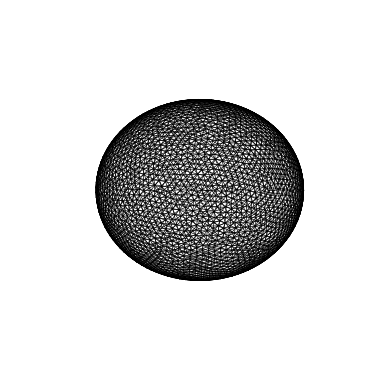

In [3]:
draw(mesh)

## Solving the problem

We start by setting the parameters: `k_values` contains the values of the thermal conductivity in the core and in the outside ring, `A` is the Joule heating, and `h` is the heat transfer.

In [4]:
k_values = {'core': 101.,  'shell': 11.}
A = 5.
h = 7.

We create bases for Quadratic elements of degree 1 and 0.

In [5]:
basis1 = skfem.Basis(mesh, skfem.ElementTetP1())
basis0 = basis1.with_element(skfem.ElementTetP0())

Next, we create a function `k` constant on all the elements.

In [6]:
k = basis0.zeros()
for s in mesh.subdomains:
    k[basis0.get_dofs(elements=s)] = k_values[s]

Then we assemble the FEM and solve the linear problem.

In [7]:
@skfem.BilinearForm
def conduction(u, v, w):
    return w.k * dot(grad(u), grad(v))
S = conduction.assemble(basis1, k=basis0.interpolate(k))

facet_basis = skfem.FacetBasis(mesh, basis1.elem, facets=mesh.boundaries['boundary'])
H = h * skfem.asm(mass, facet_basis)

core_basis = skfem.Basis(mesh, basis1.elem, elements=mesh.subdomains['core'])
b = A * skfem.asm(unit_load, core_basis)

y = skfem.solve(S + H, b)

# Output solution

In [8]:
M, Y = basis1.refinterp(y)
M.save("solution/M_gmsh.vtk", {"sol": Y})

After postprocessing on Paraview, here is a section of the solution:

![gmsh solution](solution/sol_gmsh.png)